<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Missing Data
---

### Learning Objectives
- Describe various strategies for dealing with missing data.
- Understand the assumptions we make when using strategies to handle missing data.

### Credit
This lesson is adapted from a missing data workshop that Matt Brems presented at the Open Data Science Conference ([ODSC](https://odsc.com/)).  Check out his GitHub repo [here](https://github.com/matthewbrems/missing-data-workshop?fbclid=IwAR1LGjaIen-ITLndPN1ODV1lYZBvxsHDs0DgIaPkuxpXMsQRBT8eAPI-0sI).

In [1]:
# Import libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics # module providing functions for calculating mathematical statistics of numeric data

# Set random seed.
np.random.seed(42)

In [2]:
# Bring in our data of age, partnered, children, and income data
# where income(response) is linearly related to age, partnered, and children (features)
income = pd.read_csv('../data/income.csv') 
income_missing = pd.read_csv('../data/income_missing.csv')

print(f'income shape: {income.shape}')
print(f'income missing shape: {income_missing.shape}')

income shape: (100, 4)
income missing shape: (100, 4)


In [3]:
# Check out dataframe.info() to get a feel of missing data/col data types
# the dataframe -  income has 0 missing data
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        100 non-null    float64
 1   partnered  100 non-null    int64  
 2   children   100 non-null    int64  
 3   income     100 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 3.2 KB


In [5]:
# Check out dataframe.info() to get a feel of missing data/col data types
# the dataframe -  income_missing has 30 missing data in col 'age'
income_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   children   100 non-null    int64  
 1   age        70 non-null     float64
 2   partnered  100 non-null    int64  
 3   income     100 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 3.2 KB


Further downstream, to visualize the impact from missing data vs without missing for the same age column across the 2 dataframes loaded above, we'll be looking at subplot histograms (2 rows, 1 col) multiple times to compare the effect from different imputations. 

Thus, a function has been written below to enable this plotting for ease of a single line function call at multiple places in this code notebook.

The plotting code is nothing new! We had done similar sub-plotting in 2.03 data-visualization, part 2.

In [6]:
# creating a function `compare_histograms` to compare histograms of original & imputed data
def compare_histograms(imputed_column, original_column, x_label, y_label = 'Frequency'):
    # plt.subplots nrows, ncols: Number of rows/columns of the subplot grid
    # figsize enforces 16 x 9 width x height on the subplots
    # printing the RHS of below assignment outputs a fig and a list "ax", assigned to the vars on RHS
    fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (16,9))
    
    # Set standardized axes for comparison histograms
    rnge = max(original_column) - min(original_column)
    xmin = min(original_column) - 0.02 * rnge
    xmax = max(original_column) + 0.02 * rnge
    ymax = 40
    
    # Plot the histograms for each axis
    ax[0].hist(original_column, bins = 15, color = '#185fad', alpha = 0.75)
    ax[0].set_title('Real Histogram', position = (0,1), ha = 'left', fontsize = 25)
    
    ax[1].hist(imputed_column, bins = 15, color = 'orange', alpha = 0.75, label = '', stacked = True)
    ax[1].set_title('Imputed Histogram', position = (0,1), ha = 'left', fontsize = 25)   
    ax[1].axvline(np.mean(imputed_column), color = 'darkorange', lw = 5, label = 'Imputed Mean') # vertical_ref_line with imputed_col_mean
    
    # Run the code common to both axis
    for axis in ax:
    
        # apply the limits to the subplots (ax[0]: 1st subplot, ax[1]: 2nd subplot)
        axis.set_xlim(xmin, xmax)
        axis.set_ylim(0, ymax)
        
        # a lot of the optional positional arguments that follow have been declared to have a nice-to-look at plot as we'll see further down
        # try customizing the positional args from below proposed declarations to see effect on hist plots
        # Set each subplot's labels.
        axis.set_xlabel(x_label, position = (0,0), ha = 'left', fontsize = 25, color = 'grey', alpha = 0.85)
        axis.set_ylabel(y_label, position = (0,1), ha = 'right', va = 'top', fontsize = 25, rotation = 0, color = 'grey', alpha = 0.85)
        axis.set_xticks([]) # turn-off tick lines along x-axis
        axis.set_yticks([]) # turn-off tick lines along y-axis
        
        # Draw a vertical line
        axis.axvline(np.mean(original_column), color = '#185fad', lw = 5, label = 'True Mean') # show vertical reference line with orig_col mean
        axis.legend(prop={'size': 15}, loc = 1)

    plt.tight_layout();

(<Figure size 1152x648 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

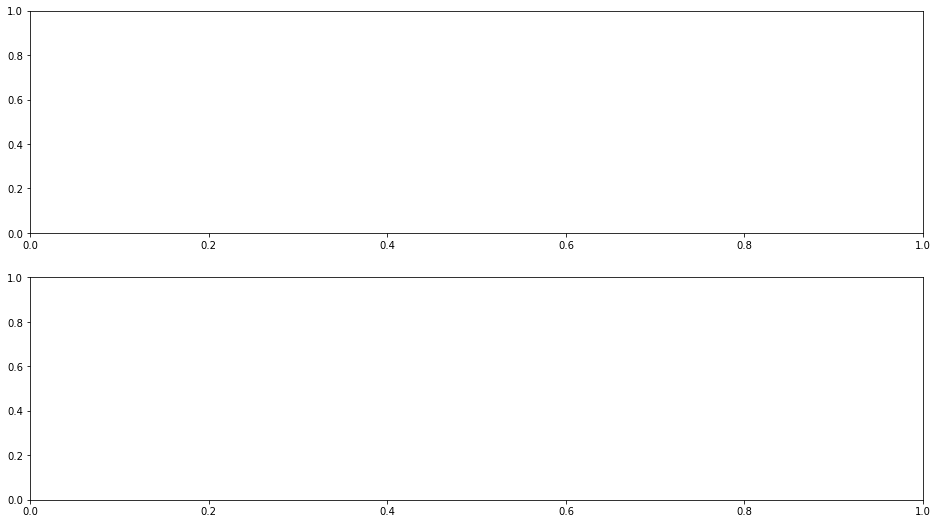

In [7]:
# understanding plt.subplots()
# first subplot: ax0, second subplot: ax1
plt.subplots(nrows = 2, ncols = 1, figsize = (16,9))

### Method 1: Deductive Imputation

We use ***logical rules*** to fill in missing values. For example,let's consider the following scenario:
- Survey asks if the respondent was the victim of _a crime_ in the last twelve months.
- Respondent says no.
- Survey then asks if the respondent was the victim of _a violent crime_ in the last twelve months.
- Respondent leaves this answer blank.

We _may_ choose to use the 1st response from the respondent saying 'no' generally, to impute missing for the 2nd response where the values were missing. But, we need to note the possible pitfalls that come with such an approach, such as these:

- Requires specific coding
- Can be time consuming
- There is definitely a chance that our assumption is not true

### Method 2: Mean/Median/Mode Imputation

For any “NA” value in a given column, replace “NA” with the **mean, median, or mode** computed from other available values in that column.

Definitions for these statistics very quickly:
- mean - the average value
- median - the mid point value
- mode - the most common value 

**Pros**:
- Quick
- Easy to implement
- Seems reasonable _(it is, a data driven approach afterall)_

**Cons**:
- Can significantly distort data distribution _(visually, histograms can confirm this)_
- Can underestimate variance
- Should only be considered if data is MCAR _(MCAR, 'Missing Completely at Random')_

#### Mean Imputation

In [8]:
# recapping the column with missing values
income_missing.isnull().sum()

children      0
age          30
partnered     0
income        0
dtype: int64

In [9]:
# Let's impute missing values in the age column with the mean from available data points
# let's first find the mean using .mean()
mean_age = income_missing['age'].mean()
mean_age

39.5

In [10]:
# next, let's create a new col in income_missing df that'll fill only the NA values from 'age' col with the mean
income_missing['age_mean_imputed'] = income_missing['age'].fillna(mean_age)

income_missing.isnull().sum() # we can see while 'age' has 30 missing data, the newly imputed col, 'age_mean_imputed' does not

children             0
age                 30
partnered            0
income               0
age_mean_imputed     0
dtype: int64

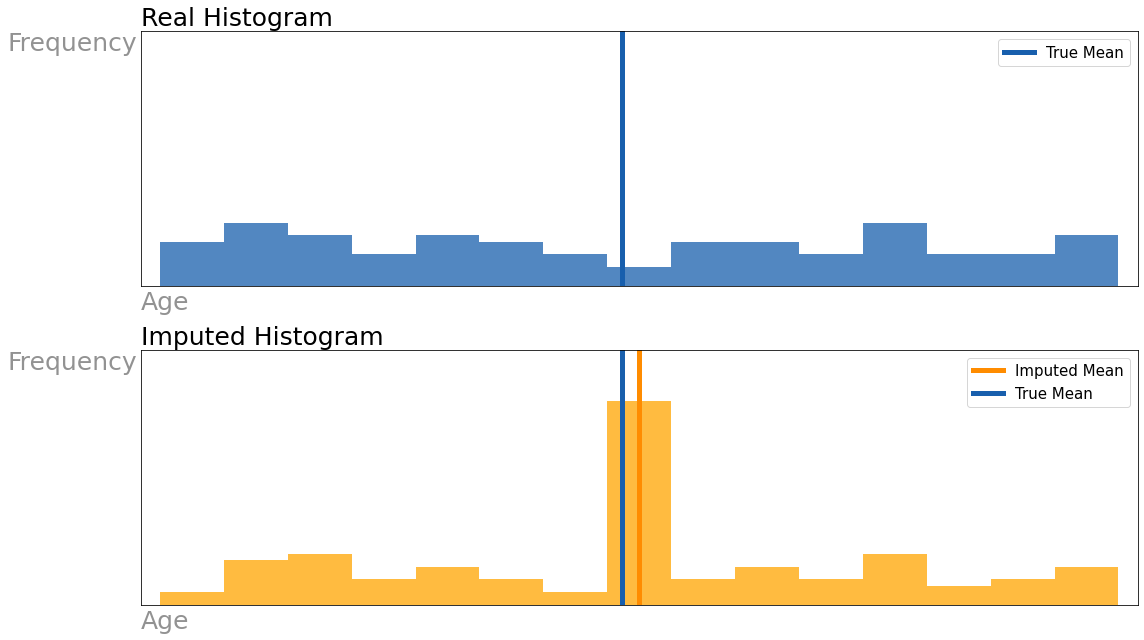

In [11]:
# let's invoke our previously defined function
# we're going to use it to compare the 'age' col from 'income' df that DOES NOT have any missing vs,
# the 'age_mean_imputed' col from 'income_missing' df that had missing values from 'age' imputed with mean from available values
compare_histograms(imputed_column = income_missing['age_mean_imputed'], # plot hist for 'age_mean_imputed' col with missing=mean
                   original_column = income['age'], # plot hist for 'age' col with NO-MISSING data
                   x_label = 'Age',
                   y_label = 'Frequency')

We are **underestimating the variance** here. Let's look at the definition for _variance_:
 - _Variance measures how distant from the mean random values are in a data set_
 - _A set of data with **low variance is dominated at the mean**_
 - _while, a set of **high variance is spread out** and deviates significantly from the mean._

In [12]:
# let's examine the variance between the imputed (for missing) vs actual (no missing) cols:
imputed_variance_m2 = (income_missing['age_mean_imputed'].std())**2
actual_variance = (income['age'].std())**2
print(f'imputed: {imputed_variance_m2:.2f}, actual: {actual_variance:.2f}')

imputed: 97.23, actual: 141.63


We can confirm from above that the variance for the imputed column is ~46% different/lower compared to actual column with no missing values. By imputing the missing values with the data distribution's mean, we artificially created a distribution that is very close to the mean, which shows up in the peak at mean value from the comparison histograms above. 

**Why is this a bad thing?**

By disturbing the natural distribution of the underlying data, and creating something that isn't very representative of the actual distribution's data spread, we are potentially disrupting statistical conclusions, like related to confidence interval/hypothesis testing.   

#### Median Imputation

Example of median.

$orignal\,list = [20,3,5,1,2,3,0,3,8]$

$sorted\,list = [0,1,2,3,3,3,5,8,20]$

Median is the middle value in the sorted list which is 3 here

In [13]:
# Let's impute missing values in the age column with the 'median' this time, instead of the above 'mean'
# median value is the value in the middle, after you have sorted all the values from smallest to largest
med_age = income_missing['age'].median()
med_age

40.5

In [14]:
# let's create a new col in income_missing df that'll fill only the NA values from 'age' col with the median
income_missing['age_med_imputed'] = income_missing['age'].fillna(med_age)

income_missing.isnull().sum() # we can see while 'age' has 30 missing data, the newly imputed col, 'age_med_imputed' does not

children             0
age                 30
partnered            0
income               0
age_mean_imputed     0
age_med_imputed      0
dtype: int64

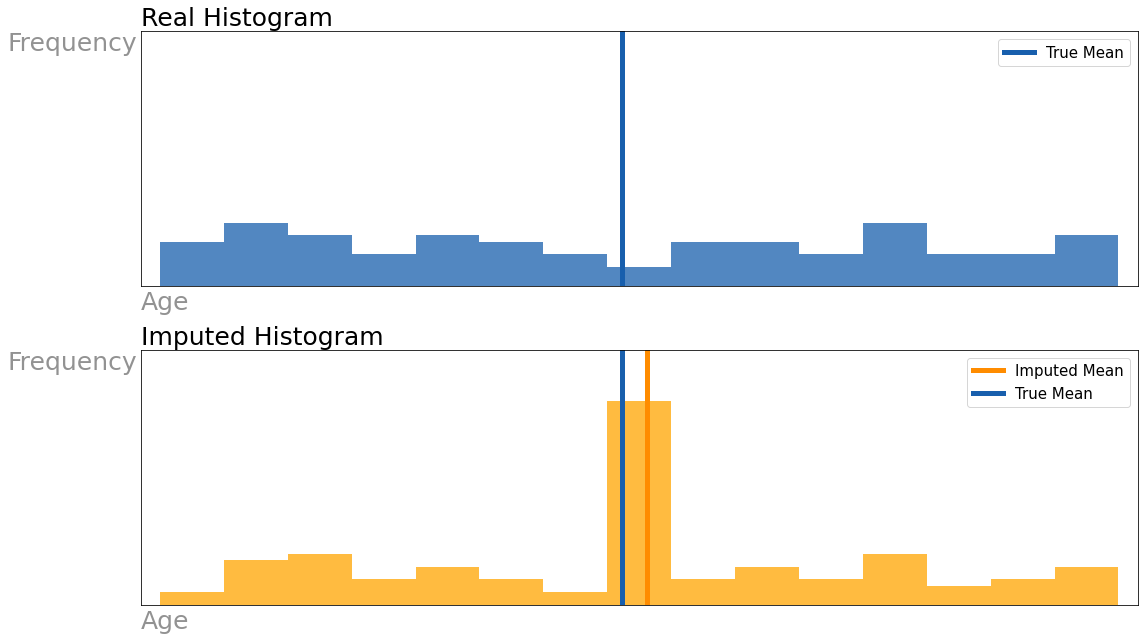

In [15]:
compare_histograms(imputed_column = income_missing['age_med_imputed'],
                   original_column = income['age'],
                   x_label = 'Age',
                   y_label = 'Frequency')

#### Mode Imputation

In [16]:
# Running df[col].mode() gives us a Series instead of a single value.
# so we use [0] to get the final value
income_missing['age'].mode()

0    44.0
dtype: float64

In [17]:
# Let's impute missing values in the age column with the mode
# Mode value is the value that appears the most number of times
mode_age = income_missing['age'].mode()[0]
mode_age

44.0

In [18]:
# let's create a new col in income_missing df that'll fill only the NA values from 'age' col with the mode
income_missing['age_mode_imputed'] = income_missing['age'].fillna(mode_age)

income_missing.isnull().sum() # we can see while 'age' has 30 missing data, the newly imputed col, 'age_mode_imputed' does not

children             0
age                 30
partnered            0
income               0
age_mean_imputed     0
age_med_imputed      0
age_mode_imputed     0
dtype: int64

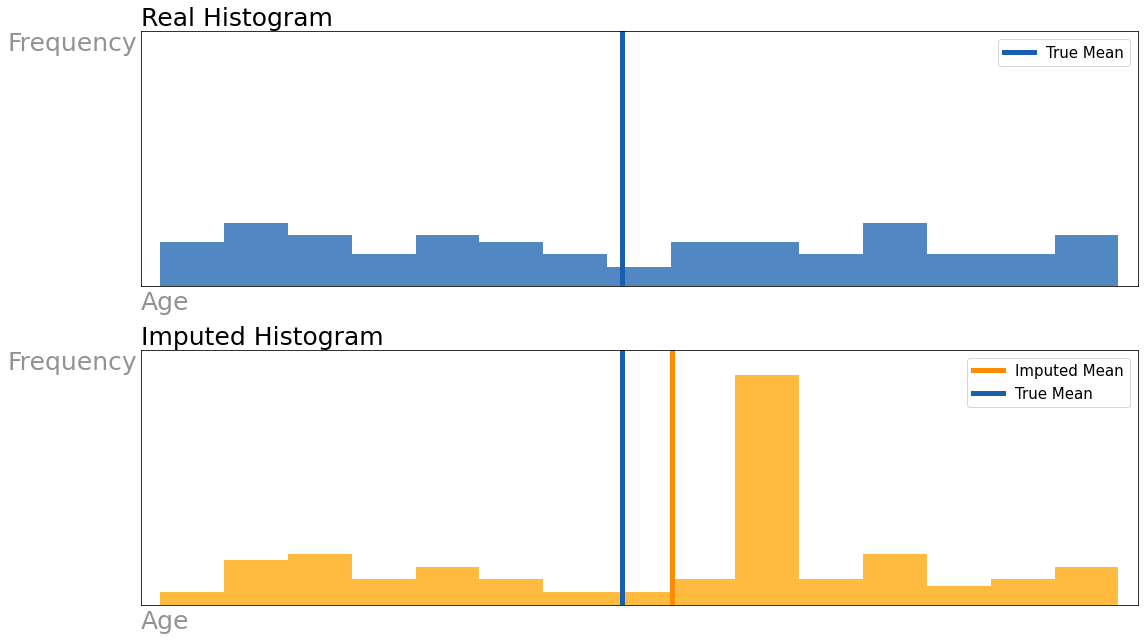

In [19]:
compare_histograms(imputed_column = income_missing['age_mode_imputed'],
                   original_column = income['age'],
                   x_label = 'Age',
                   y_label = 'Frequency')

- With each of the statistic computation, we notice the imputed column's data distribution shifting based on the applied imputation
- The gap between 'True Mean' and 'Imputed Mean' has progressively widened, for mean vs median vs mode imputation  

### Make your life easier -> <span style="color:green">Simple Imputer</span> in sklearn

Note: **Train-test-split BEFORE doing this if you are going to model later _to avoid data leakage!_**

SimpleImputer sklearn documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer).

Let's try the `mean imputation` again, this time with sklearn's `SimpleImputer` class

In [19]:
# imputation transformer for completing missing values
from sklearn.impute import SimpleImputer

In [20]:
# re-load data with missing values for 'age'
income_missing = pd.read_csv('../data/income_missing.csv') 
income_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   children   100 non-null    int64  
 1   age        70 non-null     float64
 2   partnered  100 non-null    int64  
 3   income     100 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 3.2 KB


In [21]:
# strategy='median' or 'most_frequent' are alternatively available options as well
imp = SimpleImputer(strategy = 'mean')  # instantiate

# apply imputation with mean transformation to missing values in income_missing df
imp_income_missing = imp.fit_transform(income_missing) 
imp_income_missing

array([[1.00000000e+00, 3.50000000e+01, 1.00000000e+00, 5.65313613e+04],
       [2.00000000e+00, 5.80000000e+01, 1.00000000e+00, 9.30261825e+04],
       [0.00000000e+00, 4.90000000e+01, 1.00000000e+00, 4.26930108e+04],
       [0.00000000e+00, 4.40000000e+01, 1.00000000e+00, 8.36801282e+04],
       [1.00000000e+00, 2.60000000e+01, 0.00000000e+00, 2.88455208e+04],
       [1.00000000e+00, 2.60000000e+01, 1.00000000e+00, 2.48988409e+04],
       [2.00000000e+00, 2.20000000e+01, 1.00000000e+00, 6.71520081e+04],
       [2.00000000e+00, 5.50000000e+01, 1.00000000e+00, 3.50473735e+04],
       [5.00000000e+00, 4.40000000e+01, 1.00000000e+00, 1.72458697e+04],
       [1.00000000e+00, 3.95000000e+01, 1.00000000e+00, 7.57495292e+04],
       [2.00000000e+00, 3.95000000e+01, 1.00000000e+00, 5.71769502e+04],
       [4.00000000e+00, 3.95000000e+01, 1.00000000e+00, 8.86604764e+04],
       [1.00000000e+00, 3.95000000e+01, 0.00000000e+00, 6.70892603e+04],
       [2.00000000e+00, 3.95000000e+01, 0.00000000e

In [22]:
# convert above array from imputation operation to a df for more flexible transformations/review
imp_income_missing_df = pd.DataFrame(imp_income_missing, columns = income_missing.columns)
imp_income_missing_df.head()

,children,age,partnered,income
0,1.0,35.0,1.0,56531.361287
1,2.0,58.0,1.0,93026.182530
2,0.0,49.0,1.0,42693.010819
3,0.0,44.0,1.0,83680.128218
4,1.0,26.0,0.0,28845.520835


In [23]:
imp_income_missing_df.info() # no more missing values as a result of sklearn's SimpleImputer operation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   children   100 non-null    float64
 1   age        100 non-null    float64
 2   partnered  100 non-null    float64
 3   income     100 non-null    float64
dtypes: float64(4)
memory usage: 3.2 KB


### Method 3: Single Regression Imputation

With regression imputation, the information of other variables is used to predict the missing values in a variable by using a regression model.

- Suppose I’m missing income for some people, but have all observed age and highest level of education for everybody.  
- X = age and highest level of education, y = income.
- Fit a model.
- For any “NA” value in a given column (like, `y` here), replace “NA” with predicted value from that model.

**Pros**:
- Seems reasonable
- More sophisticated approach than traditional ways of mean/median/mode imputation

**Cons**:
- Still distorts histogram
- Underestimates variance
- Should only be considered if data is MCAR or MAR. _(MAR, 'missing at random')_

In [24]:
# re-load data
income_missing = pd.read_csv('../data/income_missing.csv') 
income_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   children   100 non-null    int64  
 1   age        70 non-null     float64
 2   partnered  100 non-null    int64  
 3   income     100 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 3.2 KB


In [25]:
# Import sklearn linear regression
from sklearn.linear_model import LinearRegression

In [26]:
# Save a new subset-dataframe without any missing values
income_new = income_missing.dropna()
income_new.shape # confirms that 30 rows were dropped corresponding to missing values in 'age'

(70, 4)

In [27]:
# Set up model
X_columns = income_new[['partnered', 'children', 'income']] # take cols w/o any missing values originally for model feature matrix
impute_column = income_new['age'] # target col vector

# Instantiate model
model = LinearRegression()

# Fit (train model)
model.fit(X_columns, impute_column)

LinearRegression()

In [28]:
# Impute missing values in income_missing['age'] with the prediction from model
def age_imputed(row):
    # Check if age column is NaN
    if np.isnan(row['age']):
        # Create the X_test
        # Subset all columns that are NOT 'age'
        X_test = row[~row.index.isin(['age'])] 
        # Conver it to a DataFrame and Transpose so that each column is a column and not a row
        X_test = pd.DataFrame(X_test).T
        
        # Run predictions and return y_pred as the imputed value
        y_pred = model.predict(X_test)[0]
        return y_pred
    else:
        # If age column is not NaN then directly return the value of the age column itself
        return row['age']
    
# we'll create a new col, 'age_regression_imputed' to contain the regression imputed replacements using pandas apply on each row
income_missing['age_regression_imputed'] = income_missing.apply(age_imputed, axis=1)

Let's break down the apply function from above: 

1. In the apply function we specified `axis=1` so that we can access multiple columns within the apply function
2. In the `age_imputed` function, we are checking each row
3. If the value of the `'age'` column in that row is NaN, then we run model predictions
    1. To run predictions, we first need to generate the X_test
    2. For this, we first subset the columns that are NOT 'age'
    3. After the above step, the values from each "column" is actually in a pandas series, so we convert it to a DataFrame and Transpose so that each value is in a columns. See code below
4. If not, we return the value of the `'age'` column itself.

In [29]:
# A sample 'row'
row = income_missing.loc[9]
row

children                      1.000000
age                                NaN
partnered                     1.000000
income                    75749.529176
age_regression_imputed       42.370291
Name: 9, dtype: float64

In [30]:
# All values except 'age'
X_test = row[~row.index.isin(['age'])] 
X_test

children                      1.000000
partnered                     1.000000
income                    75749.529176
age_regression_imputed       42.370291
Name: 9, dtype: float64

In [31]:
# Convert to DataFrame, but all values are in rows!
pd.DataFrame(X_test)

,9
children,1.000000
partnered,1.000000
income,75749.529176
age_regression_imputed,42.370291


In [32]:
# Convert to DataFrame and keep each value in a column
pd.DataFrame(X_test).T

,children,partnered,income,age_regression_imputed
9,1.0,1.0,75749.529176,42.370291


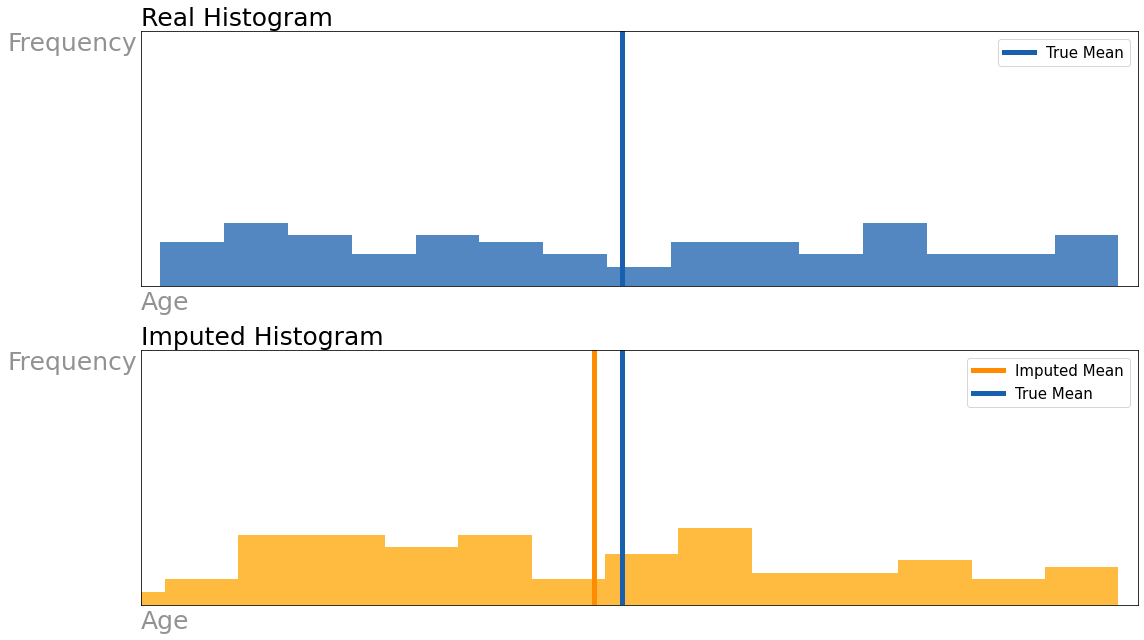

In [33]:
# let's now invoke the hist custom plotting function, this time to compare actual observations with regression imputation 
compare_histograms(imputed_column = income_missing['age_regression_imputed'],
                   original_column = income['age'],
                   x_label = 'Age',
                   y_label = 'Frequency')

### Make your life easier -> <span style="color:green">Iterative Imputer</span> in sklearn

sklearn's `IterativeImputer` is a Multivariate imputer that estimates each feature _(with missing values)_ from all the others through modeling. Documentation from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer): 
> Note: This estimator is still experimental for now: the predictions and the API might change without any deprecation cycle. To use it, you need to explicitly import enable_iterative_imputer:

```python
# explicitly requires this experimental feature
from sklearn.experimental import enable_iterative_imputer  
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
```

Again, make sure to **fit this only on training data** if you are using this for a model (you can transform testing data).

In [34]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

In [35]:
# re-load data
income_missing = pd.read_csv('../data/income_missing.csv')
income_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   children   100 non-null    int64  
 1   age        70 non-null     float64
 2   partnered  100 non-null    int64  
 3   income     100 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 3.2 KB


In [36]:
# we'll follow the same sequence as done previously with SimpleImputer
# instantiating/creating an object of the class 'IterativeImputer', with LinearReg model as estimator
it_imp = IterativeImputer(estimator = LinearRegression()) 

# apply linear regression model imputation to missing values in income_missing df
it_imp_income_missing = it_imp.fit_transform(income_missing)
it_imp_income_missing

array([[1.00000000e+00, 3.50000000e+01, 1.00000000e+00, 5.65313613e+04],
       [2.00000000e+00, 5.80000000e+01, 1.00000000e+00, 9.30261825e+04],
       [0.00000000e+00, 4.90000000e+01, 1.00000000e+00, 4.26930108e+04],
       [0.00000000e+00, 4.40000000e+01, 1.00000000e+00, 8.36801282e+04],
       [1.00000000e+00, 2.60000000e+01, 0.00000000e+00, 2.88455208e+04],
       [1.00000000e+00, 2.60000000e+01, 1.00000000e+00, 2.48988409e+04],
       [2.00000000e+00, 2.20000000e+01, 1.00000000e+00, 6.71520081e+04],
       [2.00000000e+00, 5.50000000e+01, 1.00000000e+00, 3.50473735e+04],
       [5.00000000e+00, 4.40000000e+01, 1.00000000e+00, 1.72458697e+04],
       [1.00000000e+00, 4.23702913e+01, 1.00000000e+00, 7.57495292e+04],
       [2.00000000e+00, 3.89213434e+01, 1.00000000e+00, 5.71769502e+04],
       [4.00000000e+00, 4.65827320e+01, 1.00000000e+00, 8.86604764e+04],
       [1.00000000e+00, 4.47573889e+01, 0.00000000e+00, 6.70892603e+04],
       [2.00000000e+00, 4.38576886e+01, 0.00000000e

In [37]:
# convert above array from imputation operation to a df for downstream operations
it_imp_income_missing = pd.DataFrame(it_imp_income_missing, columns = income_missing.columns)
it_imp_income_missing.head()

,children,age,partnered,income
0,1.0,35.0,1.0,56531.361287
1,2.0,58.0,1.0,93026.182530
2,0.0,49.0,1.0,42693.010819
3,0.0,44.0,1.0,83680.128218
4,1.0,26.0,0.0,28845.520835


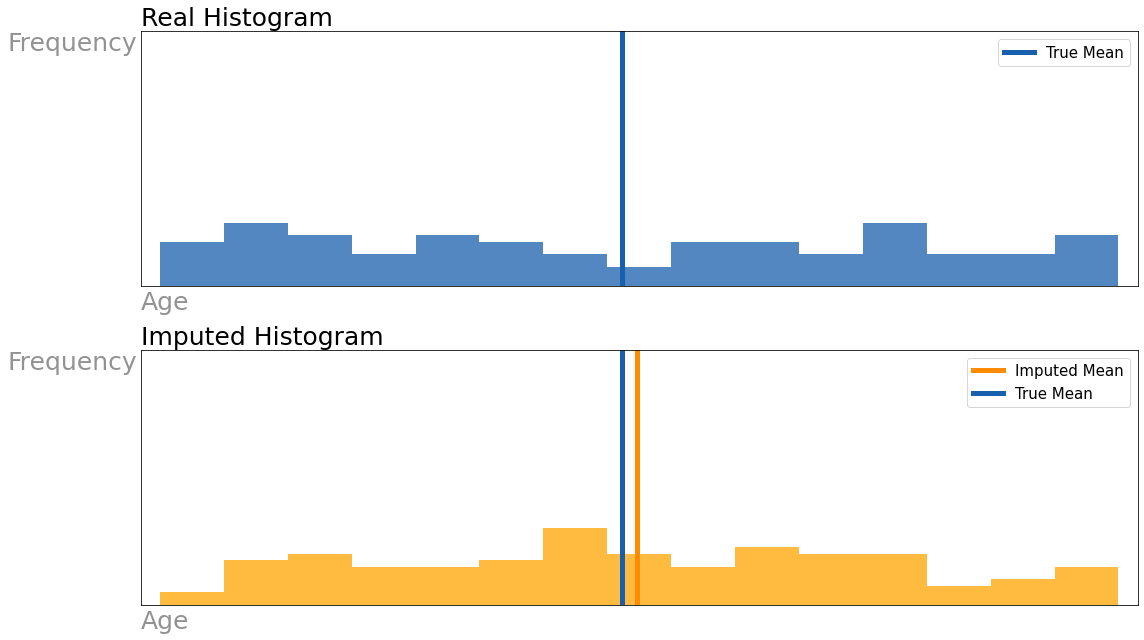

In [38]:
compare_histograms(imputed_column = it_imp_income_missing['age'],
                   original_column = income['age'],
                   x_label = 'Age',
                   y_label = 'Frequency')

In [39]:
# let's examine the variance between the imputed (for missing) vs actual (no missing) cols:
imputed_variance_m3 = (it_imp_income_missing['age'].std())**2
print(f'imputed: {imputed_variance_m3:.2f}, actual: {actual_variance:.2f}')

imputed: 103.80, actual: 141.63


We can confirm from above that the delta in variance for **Method 3** (~36% lower for imputed vs actual) has improved vs Method 2 (where the imputed column was ~46% lower for imputed vs actual). As we can confirm visually by inspecting the histogram as well, the imputed distribution does not see vastly different distributions (like we saw in Method 2 peaking at mean).

In [40]:
# try it with the default estimator = Bayesian regression
income_missing = pd.read_csv('../data/income_missing.csv') 

it_imp = IterativeImputer()
it_imp_income_missing = it_imp.fit_transform(income_missing)

it_imp_income_missing = pd.DataFrame(it_imp_income_missing, columns = income_missing.columns)

[Documentation on Bayesian Regression](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression)

Bayesian regression techniques can be used to include regularization parameters in the estimation procedure. They adapt to the data on hand. 

Tip: It's good to try how your data works with in-built default parameters, and optimize your approach from there. Because the defaults has been set internally to be generally optimal parameters.

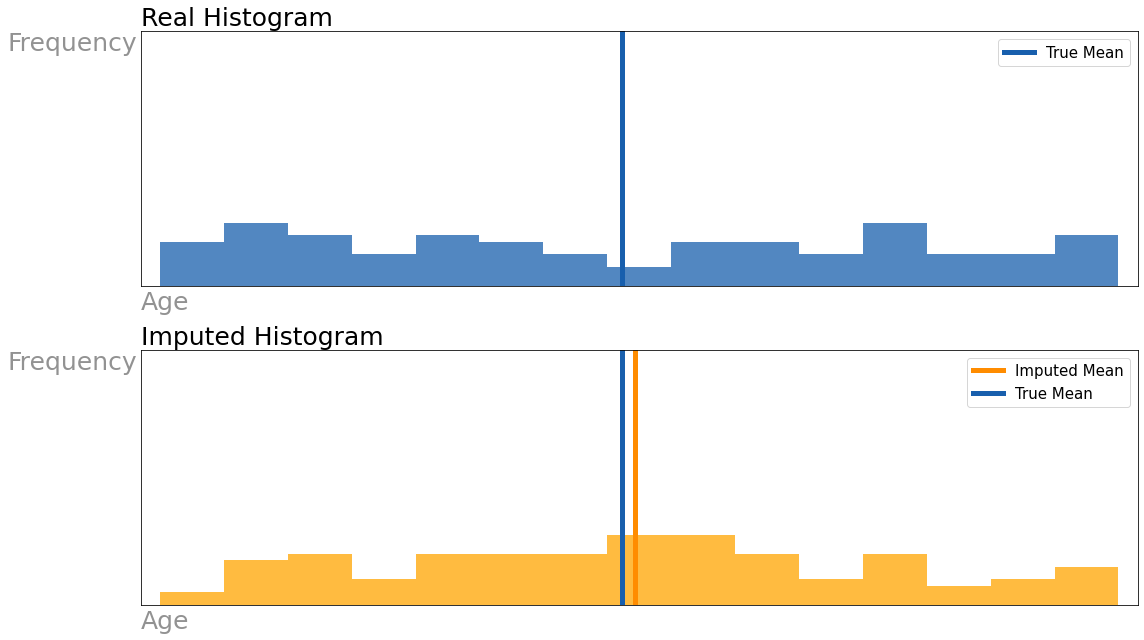

In [41]:
compare_histograms(imputed_column = it_imp_income_missing['age'],
                   original_column = income['age'],
                   x_label = 'Age',
                   y_label = 'Frequency')

In [42]:
# let's examine the variance between the imputed (for missing) vs actual (no missing) cols:
imputed_variance_m3 = (it_imp_income_missing['age'].std())**2
print(f'imputed: {imputed_variance_m3:.2f}, actual: {actual_variance:.2f}')

imputed: 100.94, actual: 141.63


This isn't really any improvement over using a LinearRegression estimator. The variance delta has infact increased to ~40% vs ~36% seen above.

### Method 4: Nearest Neighbors Imputation

Imputation for completing missing values using k-Nearest Neighbors. _(we'll separately cover more on KNN intuition and application later this week)_

By default, a euclidean distance metric that supports missing values, `nan_euclidean_distances`, is used to find the nearest neighbors. Each **missing feature is imputed using values from `n_neighbors` nearest neighbors that have a value for the feature**. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor.

[Documentation on KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer).

In [21]:
from sklearn.impute import KNNImputer

In [22]:
income_missing = pd.read_csv('../data/income_missing.csv') 

In [25]:
knn_imp = KNNImputer()
knn_imp_income_missing = knn_imp.fit_transform(income_missing)

In [23]:
knn_imp_income_missing = pd.DataFrame(knn_imp_income_missing, columns = income_missing.columns)

In [26]:
knn_imp_income_missing

array([[1.00000000e+00, 3.50000000e+01, 1.00000000e+00, 5.65313613e+04],
       [2.00000000e+00, 5.80000000e+01, 1.00000000e+00, 9.30261825e+04],
       [0.00000000e+00, 4.90000000e+01, 1.00000000e+00, 4.26930108e+04],
       [0.00000000e+00, 4.40000000e+01, 1.00000000e+00, 8.36801282e+04],
       [1.00000000e+00, 2.60000000e+01, 0.00000000e+00, 2.88455208e+04],
       [1.00000000e+00, 2.60000000e+01, 1.00000000e+00, 2.48988409e+04],
       [2.00000000e+00, 2.20000000e+01, 1.00000000e+00, 6.71520081e+04],
       [2.00000000e+00, 5.50000000e+01, 1.00000000e+00, 3.50473735e+04],
       [5.00000000e+00, 4.40000000e+01, 1.00000000e+00, 1.72458697e+04],
       [1.00000000e+00, 4.44000000e+01, 1.00000000e+00, 7.57495292e+04],
       [2.00000000e+00, 3.76000000e+01, 1.00000000e+00, 5.71769502e+04],
       [4.00000000e+00, 4.74000000e+01, 1.00000000e+00, 8.86604764e+04],
       [1.00000000e+00, 4.02000000e+01, 0.00000000e+00, 6.70892603e+04],
       [2.00000000e+00, 3.36000000e+01, 0.00000000e

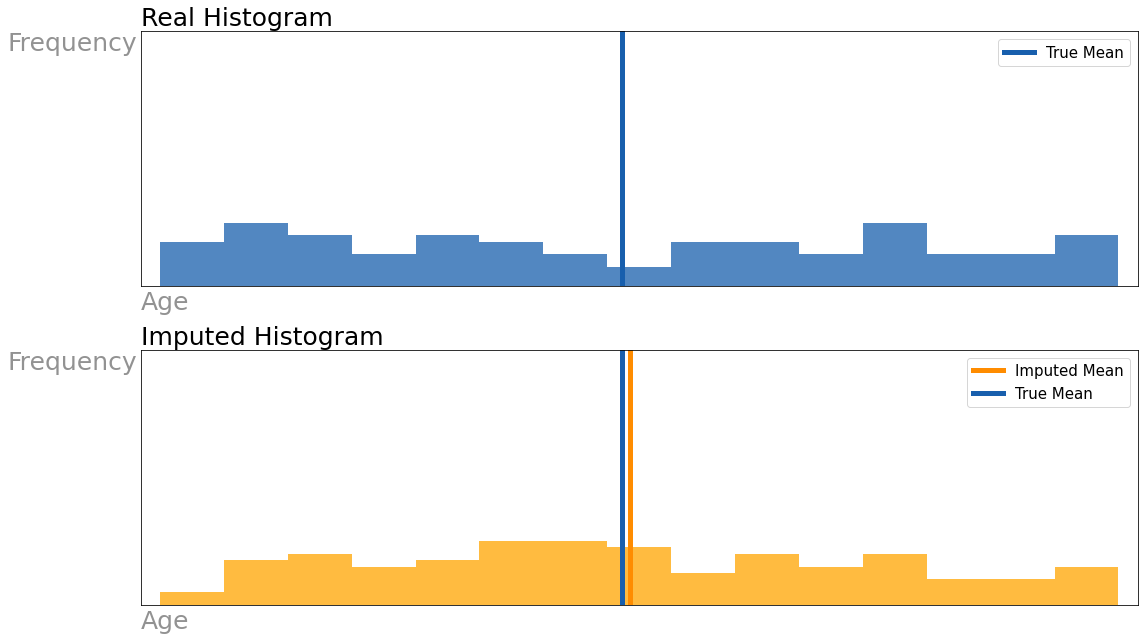

In [46]:
compare_histograms(imputed_column = knn_imp_income_missing['age'],
                   original_column = income['age'],
                   x_label = 'Age',
                   y_label = 'Frequency')

In [47]:
# let's examine the variance between the imputed (for missing) vs actual (no missing) cols:
imputed_variance_m4 = (knn_imp_income_missing['age'].std())**2
print(f'imputed: {imputed_variance_m4:.2f}, actual: {actual_variance:.2f}')

imputed: 105.17, actual: 141.63


We see that this method is slightly better (~35%) in variance comparison between imputed and actual vs Method 3. 

---
#### Deterministic vs Random Imputation 

![](../images/deterministic_imputation.png)
[image source](http://www.stat.columbia.edu/~gelman/arm/missing.pdf)

**Deterministic** regression imputation replaces missing values with the exact prediction of the regression model, without accounting for the randomness in data or in other words, Random variation (i.e. an error term) around the regression slope is not considered. Imputed values are therefore often too precise and lead to an overestimation of the correlation between X and Y.

**Stochastic** regression imputation (or, **Random** regression imputation as represented in the image above), was developed in order to solve this issue of deterministic regression imputation. Stochastic regression imputation adds a _random error_ term to the predicted value and is therefore able to reproduce the correlation of X and Y more appropriately.

[source](https://statisticsglobe.com/regression-imputation-stochastic-vs-deterministic/#:~:text=Deterministic%20regression%20imputation%20replaces%20missing,correlation%20between%20X%20and%20Y.)

### Method 5: Multiple Imputation

If we want to account for the **randomness** in our data, _(like, to be more representative of the inherent variance/spread in the dataset)_ we can ***fill in missing values with some amount of randomness/uncertainty***. _(like, the Random Imputation approach above)_

Replacing an NA with one value treats things like we know the true value.

Therefore, lets try to **impute multiple times**.
- We will make multiple copies of our dataset.
- We will use [random regression imputation](https://statisticsglobe.com/regression-imputation-stochastic-vs-deterministic/) to generate one value for each NA in each of our copied dataset.
- Once each of our copied datasets are missing-values-imputed, we will do our “final model” or “final analysis” on each of the copied datasets.
- We will then combine the results of our multiple models together, just like we aggregate results in cross-validation that we've seen before, or an ensemble model. _(ensembling is just combining multiple into one)_

![](../images/proper_imputation.png)


If you’re **generating predictions**, you can just average your predictions together in a regression problem or select the plurality class in a classification problem. _(Plurality is just the generalization of majority/taking the most frequent class and return that as a prediction)_

If your goal is to do **inference** (e.g. understand how X affects Y) and are fitting a linear model to each dataset, then you get a slope and y-intercept for each model.
- There are a set of tools, called Rubin’s rules, that will allow you to take the slopes and y-intercepts from each model and combine them together.
- Check out documentation in the repo if interested!

[IterativeImputer](https://scikit-learn.org/stable/modules/impute.html#multiple-vs-single-imputation) in sklearn can help with this!

When we used **IterativeImputer** in `Method 3`, it ran single imputation cycle vs multiple as described in this intuition here. However, we can expand on the same IterativeImputer to use for multiple imputations by applying it repeatedly to the same dataset with different random seeds when `sample_posterior=True` (the default for this parameter is set to False). 

Arguably, this method is complicated to understand and is not something you would use often in my experience. Whenever in doubt, pls experiment with different methods and pick the one that gives you the best results with the least complexity!

### Missing Indicator Column

We can add a column about which values were imputed/missing and use that as a feature in our model. This can help when there is a pattern in what is missing and our target and may help our model.

See an example of this [here](https://nbviewer.jupyter.org/github/justmarkham/scikit-learn-tips/blob/master/notebooks/09_add_missing_indicator.ipynb).

There are several ways we can do this:
1. Set `add_indicator = True` in [Simple Imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) or [Iterative Imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer):
```python
imputer = SimpleImputer(add_indicator=True)
imputer.fit_transform(X)
```
2. Use the `MissingIndicator` transformer in [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.impute.MissingIndicator.html#sklearn.impute.MissingIndicator).

In [48]:
income_missing = pd.read_csv('../data/income_missing.csv') 
income_missing.tail()

,children,age,partnered,income
95,1,40.0,1,74090.088031
96,1,41.0,1,52304.403273
97,3,37.0,0,10688.919618
98,4,NaN,0,68232.834868
99,4,24.0,1,36785.514708


In [49]:
it_imp = SimpleImputer(strategy='median', add_indicator=True)
# we're not passing: columns = income_missing.columns unlike previously, because we have 1 extra col#4 which is the 'MissingIndicator',
# a value of "1" in this column indicates placeholder for a missing value, like 'age' index#98

it_imp_income_missing = it_imp.fit_transform(income_missing) 
pd.DataFrame(it_imp_income_missing).tail()

,0,1,2,3,4
95,1.0,40.0,1.0,74090.088031,0.0
96,1.0,41.0,1.0,52304.403273,0.0
97,3.0,37.0,0.0,10688.919618,0.0
98,4.0,40.5,0.0,68232.834868,1.0
99,4.0,24.0,1.0,36785.514708,0.0


### BONUS: Pattern Submodel Approach _(Intuition)_ 
_(We don't have a way to implement this practically like through sklearn)_

Big Picture: We will break our dataset into subsets based on missingness pattern _(indicated by each of the different colors below)_. And then fitting a model to each subset, in order to predict the values, thus creating many different models.

![](../images/pattern_submodel.jpeg)

[image source](https://opendatascience.com/data-imputation-beyond-mean-median-and-mode/)

**Pros**:
- The pattern submodel method will outperform imputation methods when your data are NMAR, and will perform about as well as imputation methods when your data are MCAR or MAR.
- You can generate predictions for test observations containing missing data.
- It does not require missingness assumptions!

**Cons**:
- This is not a well-understood method for inference.

Read more about this method [here](https://academic.oup.com/biostatistics/article/21/2/236/5092384).

See an example of this [here](https://github.com/sarahmercaldo/MissingDataAndPrediction) - note that this example is done in R.

---